In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy import special
import pandas as pd
import json

In [2]:
RAW_DATA_FOLDER      = 'raw-data'
MICRORNG_SAMPLE_PATH = os.path.join(RAW_DATA_FOLDER, 'randomsamples202001161458.bin')
TIME_SAMPLE_PATH     = os.path.join(RAW_DATA_FOLDER, 'millis202001161818.bin')
NUMPY_RANDINT_PATH   = os.path.join(RAW_DATA_FOLDER, 'numpyrandint202101311955.bin')

OUTPUT_DIR = 'test-results'

NUMPY_RNG_STATE_FILE = 'numpyrandomstate20210131.json'

In [3]:
#https://stackoverflow.com/a/38165503
def save_numpy_random_state(fpath):
    (rnd0,rnd1,rnd2,rnd3,rnd4) = np.random.get_state()
    rnd1 = [int(number) for number in rnd1]
    rand_seed = (rnd0,rnd1,rnd2,rnd3,rnd4)
    result = {}
    result['numpy_rng_state'] = rand_seed
    
    with open(fpath,'w+') as f:
        json.dump(result,f)

def restore_numpy_random_state(fpath):
    with open(fpath,'r+') as f:
        results = json.load(f)
    
    (rnd0,rnd1,rnd2,rnd3,rnd4) = results['numpy_rng_state']
    rnd1 = [np.uint32(number) for number in rnd1]
    rand_seed = (rnd0,rnd1,rnd2,rnd3,rnd4)
    np.random.set_state(rand_seed)

np.random.seed(None)
#save_numpy_random_state(NUMPY_RNG_STATE_FILE)
restore_numpy_random_state(NUMPY_RNG_STATE_FILE)

In [4]:
rng_data = np.fromfile(\
   MICRORNG_SAMPLE_PATH, 
   dtype=np.uint8)
print("Number of bytes in '%s' is %d" % (MICRORNG_SAMPLE_PATH, rng_data.shape[0]))

Number of bytes in 'raw-data/randomsamples202001161458.bin' is 66171


In [5]:
time_data = np.fromfile(\
   TIME_SAMPLE_PATH, 
   dtype=np.uint8)
print("Number of bytes in '%s' is %d" % (TIME_SAMPLE_PATH, time_data.shape[0]))

Number of bytes in 'raw-data/millis202001161818.bin' is 67119


In [6]:
#randint_data = np.random.randint(256, size=rng_data.shape[0], dtype = np.uint8)
#randint_data.tofile(NUMPY_RANDINT_PATH)
randint_data = np.fromfile(NUMPY_RANDINT_PATH,dtype=np.uint8)

In [7]:
def save_csv(data, fname):
    csv_data = np.empty((data.shape[0],2), dtype=np.int)
    csv_data[:,0] = np.arange(1, data.shape[0]+1)
    csv_data[:,1] = data
    np.savetxt(
        fname, 
        csv_data, 
        delimiter=',', 
        fmt='%d', 
        header='Index, Value', 
        comments='')

In [8]:
save_csv(
    rng_data,        
    os.path.join(OUTPUT_DIR, 'microrngdata.csv'))
save_csv(
    time_data,       
    os.path.join(OUTPUT_DIR, 'timedata.csv'))
save_csv(
    randint_data,    
    os.path.join(OUTPUT_DIR, 'randintdata.csv'))
save_csv(
    rng_data[:1001], 
    os.path.join(OUTPUT_DIR, 'microrngdata1000.csv'))
save_csv(
    time_data[:1001],
    os.path.join(OUTPUT_DIR, 'timedata1000.csv'))
save_csv(
    randint_data[:1001], 
    os.path.join(OUTPUT_DIR, 'randintdata1000.csv'))

In [9]:
def save_lagplot_data(data, fname):
    csv_data = np.empty((data.shape[0]-1,2), dtype=np.int)
    csv_data[:,0] = data[1:]
    csv_data[:,1] = data[:-1]
    np.savetxt(
        fname, 
        csv_data, 
        delimiter=',', 
        fmt='%d', 
        header='X, Y', 
        comments='')
    
def lagging_plot_scatter(ax1, data, size=(10,10), title = None):
    ax1.plot(data[1:],data[:-1], '.')
    
def lagging_plot_2dhist(ax1, data, n_bins=64, size=(10,10), title = None):
    ax1.hist2d(data[1:], data[:-1], n_bins)[3]    
    if title:
        ax1.set_title(title)

def lagging_plot_both(\
      data, 
      scatter_limit = None,
      n_bins=64, 
      size=(21,10), 
      title = None):
    
    fig1, (ax1, ax2) = plt.subplots(1,2)
    x,y = data[1:], data[:-1]
    if scatter_limit is None:
        ax1.plot(x, y, '.')
    else:
        ax1.plot(x[:scatter_limit], y[:scatter_limit], '.')
    ax2.hist2d(x, y, n_bins, density=True, cmap='binary')   
    fig1.set_size_inches(size)
    return fig1

def plot_1d(data, size=(20,10), title = None):
    fig1, ax1 = plt.subplots()
    ax1.tick_params(labelsize = 20)
    ax1.plot(data, '.')
    if title:
        ax1.set_title(title, fontsize=20)
    fig1.set_size_inches(size)
    return fig1

In [10]:
save_lagplot_data(
    rng_data[:16000], 
    os.path.join(OUTPUT_DIR,'micrornglagdata.csv'))
save_lagplot_data(
    time_data[:16000], 
    os.path.join(OUTPUT_DIR,'timelagdata.csv'))
save_lagplot_data(
    randint_data[:16000], 
    os.path.join(OUTPUT_DIR,'randintlagdata.csv'))

In [11]:
plt.ioff()

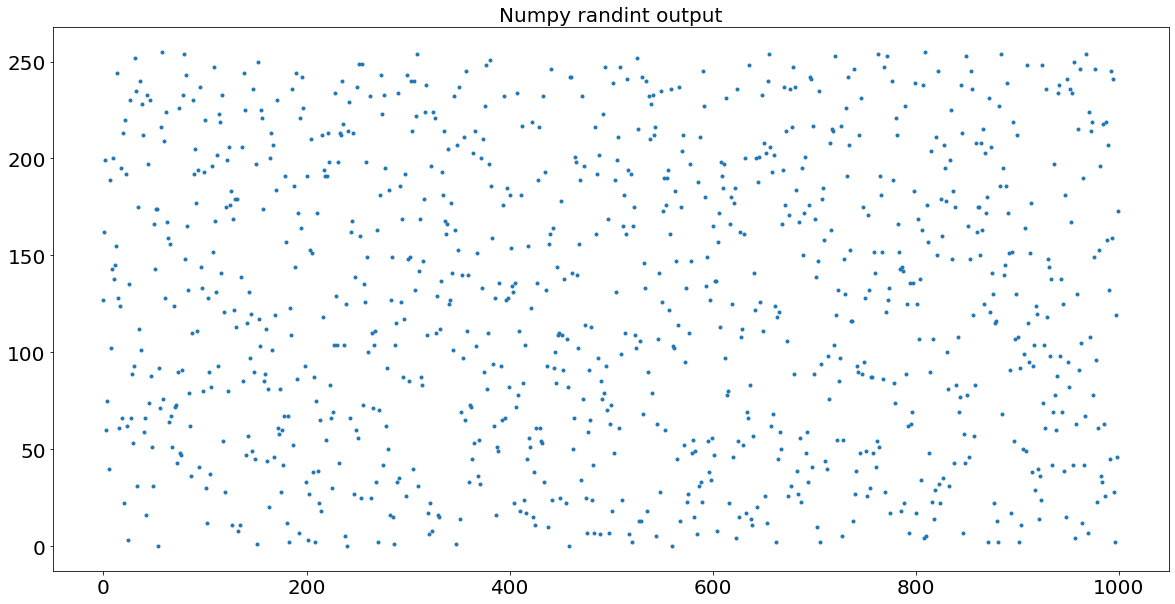

In [12]:
plot_1d(randint_data[:1000], title='Numpy randint output')

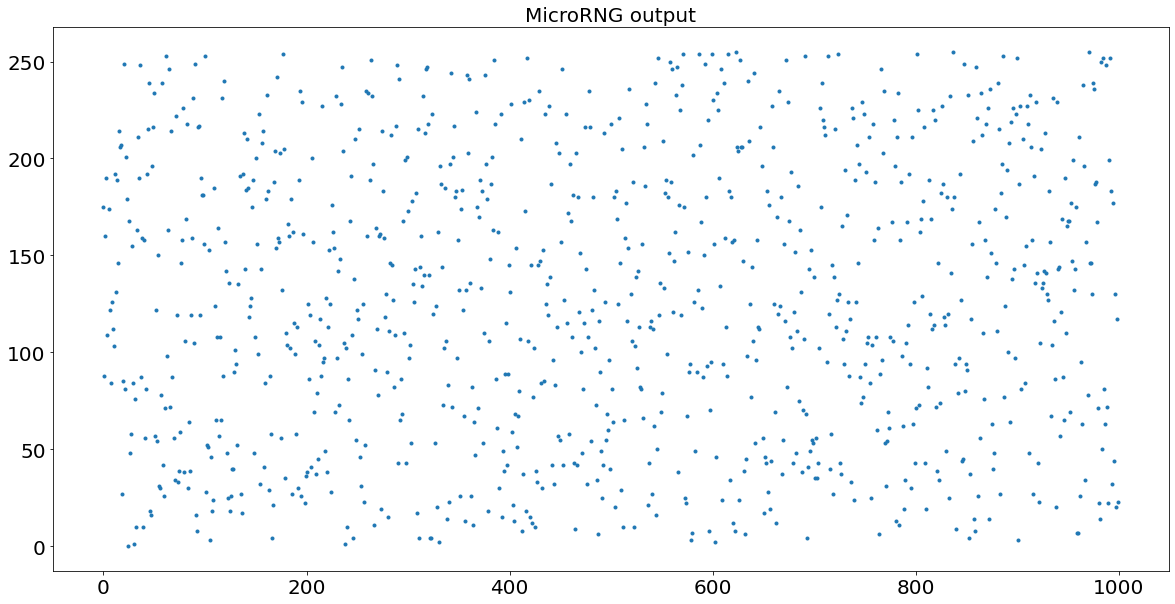

In [13]:
plot_1d(rng_data[:1000], title='MicroRNG output')

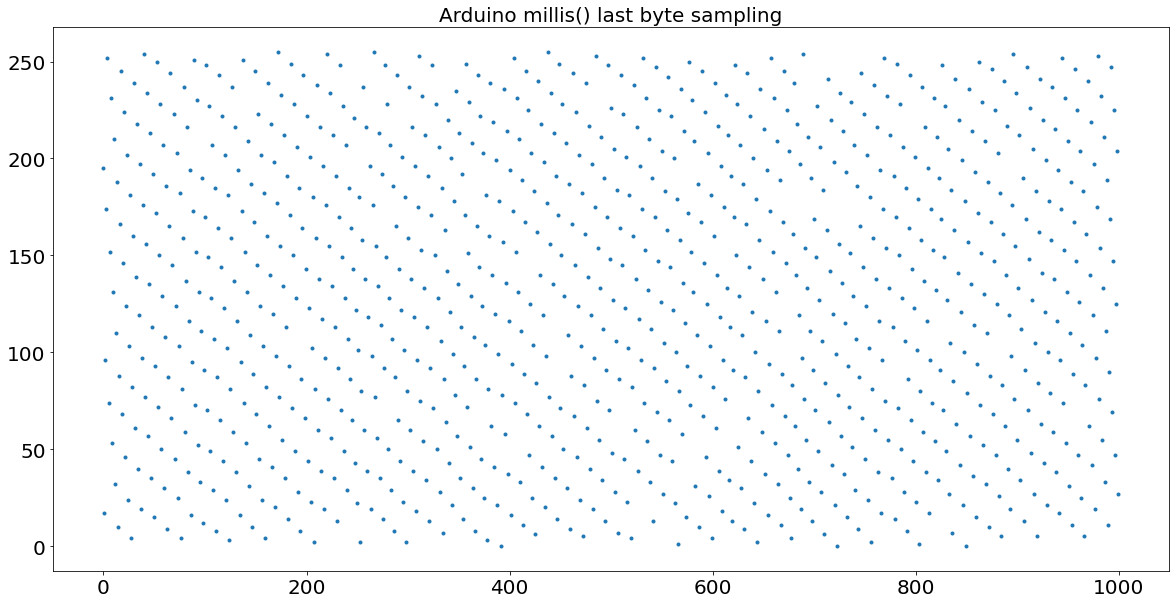

In [14]:
plot_1d(time_data[:1000], title='Arduino millis() last byte sampling')

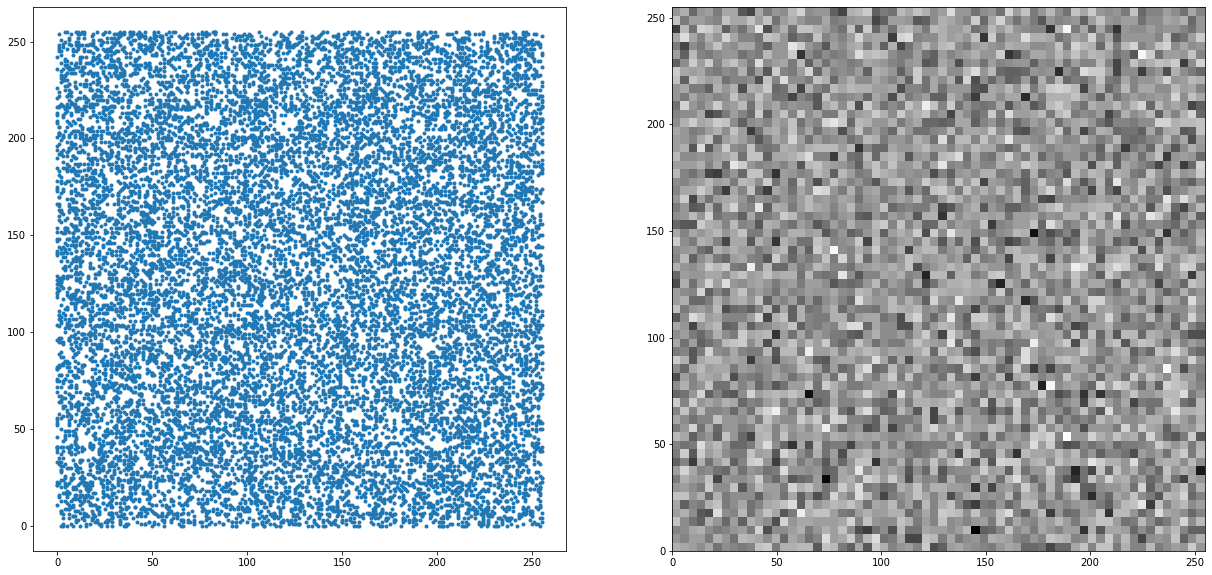

In [15]:
lagging_plot_both(randint_data, scatter_limit=16000)

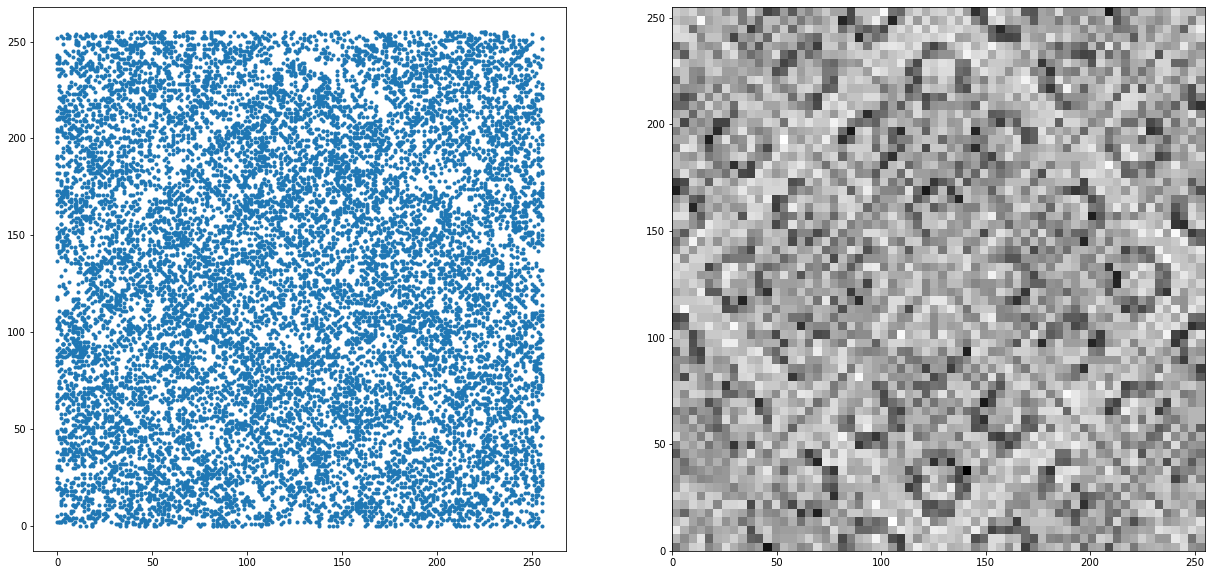

In [16]:
lagging_plot_both(rng_data, scatter_limit=16000)

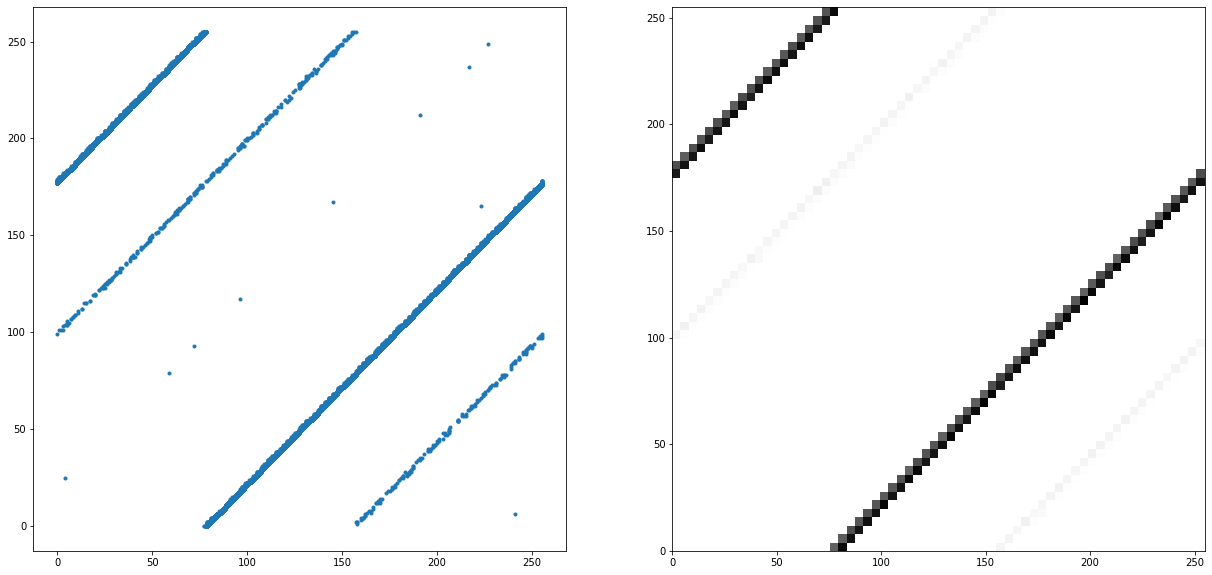

In [17]:
lagging_plot_both(time_data, scatter_limit=16000)

In [18]:
def save_hist2d_64(data, f_path):
    edges = np.empty((65,))
    edges[0]=-0.5
    edges[1:]=np.arange(4,257,4)+0.5
    
    x,y = data[1:], data[:-1]
    
    hist_count,_,_ = np.histogram2d(x,y,bins=edges)
    hist_density,_,_ = np.histogram2d(x,y,bins=edges, density = True)
    hist_count_rescaled = hist_count/np.max(hist_count)
    
    cell_centers=np.arange(2,255,4)+0.5
    hist_X, hist_Y = np.meshgrid(cell_centers,cell_centers)
    
    hist_xyv_data = np.column_stack(
        (hist_X.flatten(),
         hist_Y.flatten(),
         hist_count.flatten(),
         hist_count_rescaled.flatten(),
         hist_density.flatten()))
    
    np.savetxt(
        f_path, 
        hist_xyv_data, 
        delimiter=',', 
        fmt=('%5.1f','%5.1f', '%d', '%f', '%f'), 
        header='X, Y, NPoints, NPointsRescaled, Density', 
        comments='')
            

In [19]:
save_hist2d_64(
    randint_data, 
    os.path.join(OUTPUT_DIR,'randint-2dhist64.csv'))
save_hist2d_64(
    rng_data, 
    os.path.join(OUTPUT_DIR,'microrng-2dhist64.csv'))
save_hist2d_64(
    time_data, 
    os.path.join(OUTPUT_DIR,'time-2dhist64.csv'))

In [20]:
x,y = np.meshgrid([0,1,2],[0,1,2])
np.column_stack(
        (x.flatten(),
         y.flatten()))

array([[0, 0],
       [1, 0],
       [2, 0],
       [0, 1],
       [1, 1],
       [2, 1],
       [0, 2],
       [1, 2],
       [2, 2]])

In [21]:
def get_frequencies(data):
  values, counts=np.unique(data, return_counts=True)
  frequencies = np.zeros(256, dtype=np.int)
  frequencies[values] = counts
  return frequencies

def chisquare_uniform_test(data):
  frequencies = get_frequencies(data)
  return ss.chisquare(frequencies)

In [22]:
chisquare_uniform_test(randint_data)

Power_divergenceResult(statistic=253.3417811427967, pvalue=0.5175656803487247)

In [23]:
chisquare_uniform_test(rng_data)

Power_divergenceResult(statistic=239.25174169953607, pvalue=0.7525574558896705)

In [24]:
chisquare_uniform_test(time_data)

Power_divergenceResult(statistic=252.76322650814225, pvalue=0.5278193646123572)

In [25]:
#https://stackoverflow.com/a/22393440
ss.kstest(randint_data.astype(np.int), ss.randint.cdf, args=(0,256))

KstestResult(statistic=0.005813240977920797, pvalue=0.02275245760522088)

In [26]:
ss.kstest(rng_data.astype(np.int), ss.randint.cdf, args=(0,256))

KstestResult(statistic=0.006586332664611394, pvalue=0.006394951675677287)

In [27]:
ss.kstest(time_data.astype(np.int), ss.randint.cdf, args=(0,256))

KstestResult(statistic=0.004744080942058138, pvalue=0.09716578885661276)